# BAX 453 Final Project

In [1]:
import gzip
import json
import pandas as pd
import nltk
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from nltk.tokenize.treebank import TreebankWordDetokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize.toktok import ToktokTokenizer
import re
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC


In [2]:
data = [json.loads(d) for d in gzip.open('C:/Users/dell/Downloads/reviews_Health_and_Personal_Care_5.json.gz', 'r')]

In [3]:

df=pd.DataFrame(data)

In [4]:
df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,ALC5GH8CAMAI7,159985130X,AnnN,"[1, 1]",This is a great little gadget to have around. ...,5.0,Handy little gadget,1294185600,"01 5, 2011"
1,AHKSURW85PJUE,159985130X,"AZ buyer ""AZ buyer""","[1, 1]",I would recommend this for a travel magnifier ...,4.0,Small & may need to encourage battery,1329523200,"02 18, 2012"
2,A38RMU1Y5TDP9,159985130X,"Bob Tobias ""Robert Tobias""","[75, 77]",What I liked was the quality of the lens and t...,4.0,Very good but not great,1275955200,"06 8, 2010"
3,A1XZUG7DFXXOS4,159985130X,Cat lover,"[56, 60]",Love the Great point light pocket magnifier! ...,4.0,great addition to your purse,1202428800,"02 8, 2008"
4,A1MS3M7M7AM13X,159985130X,Cricketoes,"[1, 1]",This is very nice. You pull out on the magnifi...,5.0,Very nice and convenient.,1313452800,"08 16, 2011"
...,...,...,...,...,...,...,...,...,...
346350,A11J1FHCK5U06J,B00LJBMCKK,Karinna Ball,"[1, 1]",My appetite is definitely suppressed - my ener...,5.0,Great ingredients!,1405555200,"07 17, 2014"
346351,AFVKI7BCS3FSX,B00LJBMCKK,Laura hogan,"[0, 0]",I was drawn to this particular brand because o...,5.0,Great!,1405468800,"07 16, 2014"
346352,A1Y3FEUELH3FTI,B00LJBMCKK,Onlinesalesgirl,"[0, 0]","Great Product, Gave extra energy without the j...",5.0,Energy minus the jitters,1405123200,"07 12, 2014"
346353,A11LC938XF35XN,B00LJBMCKK,"SJ Blouse ""Stacey""","[0, 0]",I get lots of energy from this product. I felt...,5.0,I get lots of energy from this product.,1405641600,"07 18, 2014"


In [6]:
df['reviewText'].head(5)

0    This is a great little gadget to have around. ...
1    I would recommend this for a travel magnifier ...
2    What I liked was the quality of the lens and t...
3    Love the Great point light pocket magnifier!  ...
4    This is very nice. You pull out on the magnifi...
Name: reviewText, dtype: object

In [7]:
df['overall'].value_counts()

5.0    211633
4.0     68168
3.0     33254
2.0     16754
1.0     16546
Name: overall, dtype: int64

<AxesSubplot:>

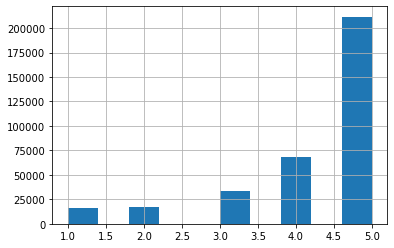

In [8]:
df['overall'].hist(figsize=(6,4))

In [9]:
#Assign labels to the data based on ratings less than and equal to 3 as 'Negative', and greater than 3 as 'Positive'
df.loc[df['overall']<=3,'review_label']= "Negative"
df.loc[df['overall']>3,'review_label']="Positive"


In [10]:
df[['overall','review_label']].value_counts()

overall  review_label
5.0      Positive        211633
4.0      Positive         68168
3.0      Negative         33254
2.0      Negative         16754
1.0      Negative         16546
dtype: int64

<AxesSubplot:>

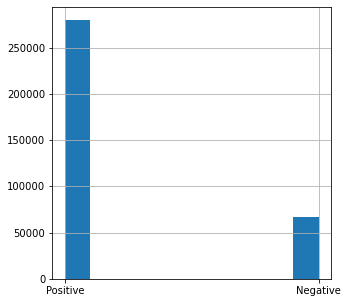

In [11]:
df['review_label'].hist(figsize=(5,5))

In [12]:
###Forming stoplist containing English  Stopwords

nltk.download('stopwords')
from nltk.corpus import stopwords
stopword = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
df_new=df.copy()

In [14]:
df_new['review_label'].value_counts()

Positive    279801
Negative     66554
Name: review_label, dtype: int64

In [15]:
df_new.loc[df_new['overall']<=3,'review_label']= 0
#df.loc[df['overall']==3,'review_label']="Neutral"
df_new.loc[df_new['overall']>3,'review_label']=1

In [16]:
df_new['review_label']=df_new['review_label'].astype('int')

In [17]:
df_new.dtypes

reviewerID         object
asin               object
reviewerName       object
helpful            object
reviewText         object
overall           float64
summary            object
unixReviewTime      int64
reviewTime         object
review_label        int32
dtype: object

In [18]:

#Function for removing all alphanumeric characters and string less than 4 characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'\b\w{1,3}\b'
    text=re.sub(pattern,'',text)
    text=re.sub(r"[0-9]+[a-z]+","",text)
    return text
#Apply function on review column
df_new['reviewText']=df_new['reviewText'].apply(remove_special_characters)

In [19]:
df_new

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,review_label
0,ALC5GH8CAMAI7,159985130X,AnnN,"[1, 1]",This great little gadget have around. ' al...,5.0,Handy little gadget,1294185600,"01 5, 2011",1
1,AHKSURW85PJUE,159985130X,"AZ buyer ""AZ buyer""","[1, 1]",would recommend this travel magnifier occ...,4.0,Small & may need to encourage battery,1329523200,"02 18, 2012",1
2,A38RMU1Y5TDP9,159985130X,"Bob Tobias ""Robert Tobias""","[75, 77]",What liked quality lens built light. ...,4.0,Very good but not great,1275955200,"06 8, 2010",1
3,A1XZUG7DFXXOS4,159985130X,Cat lover,"[56, 60]",Love Great point light pocket magnifier! wor...,4.0,great addition to your purse,1202428800,"02 8, 2008",1
4,A1MS3M7M7AM13X,159985130X,Cricketoes,"[1, 1]",This very nice. pull magnifier when want...,5.0,Very nice and convenient.,1313452800,"08 16, 2011",1
...,...,...,...,...,...,...,...,...,...,...
346350,A11J1FHCK5U06J,B00LJBMCKK,Karinna Ball,"[1, 1]",appetite definitely suppressed - energy lev...,5.0,Great ingredients!,1405555200,"07 17, 2014",1
346351,AFVKI7BCS3FSX,B00LJBMCKK,Laura hogan,"[0, 0]",drawn this particular brand because natu...,5.0,Great!,1405468800,"07 16, 2014",1
346352,A1Y3FEUELH3FTI,B00LJBMCKK,Onlinesalesgirl,"[0, 0]","Great Product, Gave extra energy without jitt...",5.0,Energy minus the jitters,1405123200,"07 12, 2014",1
346353,A11LC938XF35XN,B00LJBMCKK,"SJ Blouse ""Stacey""","[0, 0]",lots energy from this product. felt sluggi...,5.0,I get lots of energy from this product.,1405641600,"07 18, 2014",1


# Bag of Words with n-Gram

In [25]:
###Forming Bag of Words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(df_new.reviewText,df_new.review_label,test_size=.2,random_state=0)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

#cv = CountVectorizer(analyzer = 'word', stop_words=stopword,ngram_range=(2, 2),max_features=10000)
cv = CountVectorizer(analyzer = 'word', stop_words=stopword,max_features=5000,ngram_range=(1, 1))
X_train = cv.fit_transform(X_train)
X_test = cv.transform(X_test)

X_train

(277084,) (69271,) (277084,) (69271,)


<277084x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 8584637 stored elements in Compressed Sparse Row format>

In [26]:
#Checking the distribution on train data
dist=pd.DataFrame(y_train.value_counts()/y_train.shape[0]).reset_index()
dist

,index,review_label
0,1,0.807622
1,0,0.192378


In [27]:
#Checking the distribution on test data
dist_test=pd.DataFrame(y_test.value_counts()/y_test.shape[0]).reset_index()
dist_test

,index,review_label
0,1,0.808737
1,0,0.191263


In [28]:
##Getting unique feature names from bag of words

feature_names = cv.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
print("features from 200 to 300:\n{}".format(feature_names[200:300]))


Number of features: 5000
features from 200 to 300:
['anti', 'antibacterial', 'antibiotic', 'antibiotics', 'antihistamine', 'antioxidant', 'antioxidants', 'antiperspirant', 'antiperspirants', 'antiseptic', 'anxiety', 'anxious', 'anybody', 'anyhow', 'anymore', 'anyone', 'anything', 'anytime', 'anyway', 'anyways', 'anywhere', 'apart', 'apartment', 'apparent', 'apparently', 'appeal', 'appealing', 'appear', 'appearance', 'appeared', 'appears', 'appetite', 'apple', 'appliance', 'appliances', 'application', 'applications', 'applicator', 'applicators', 'applied', 'applies', 'apply', 'applying', 'appointment', 'appreciate', 'appreciated', 'approach', 'appropriate', 'approved', 'approx', 'approximately', 'april', 'arch', 'arches', 'area', 'areas', 'arginine', 'armpit', 'armpits', 'arms', 'arnica', 'aroma', 'aromatherapy', 'around', 'arrival', 'arrive', 'arrived', 'arrives', 'arsenal', 'arthritic', 'arthritis', 'article', 'articles', 'artificial', 'ascorbic', 'aside', 'asked', 'asking', 'asleep',

# Classification Models

# Logistic regression BOW with n-Gram

In [29]:
### Logistic regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=13)
logreg.fit(X_train, y_train)
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))


Training set score: 0.865
Test set score: 0.857


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [30]:
#Classification report for Logistic Regression 
log_predict=logreg.predict(X_test)
log_bow_report=classification_report(y_test,log_predict,target_names=['Negative','Positive'])
print(log_bow_report)


              precision    recall  f1-score   support

    Negative       0.71      0.42      0.53     13249
    Positive       0.88      0.96      0.92     56022

    accuracy                           0.86     69271
   macro avg       0.79      0.69      0.72     69271
weighted avg       0.84      0.86      0.84     69271



<AxesSubplot:>

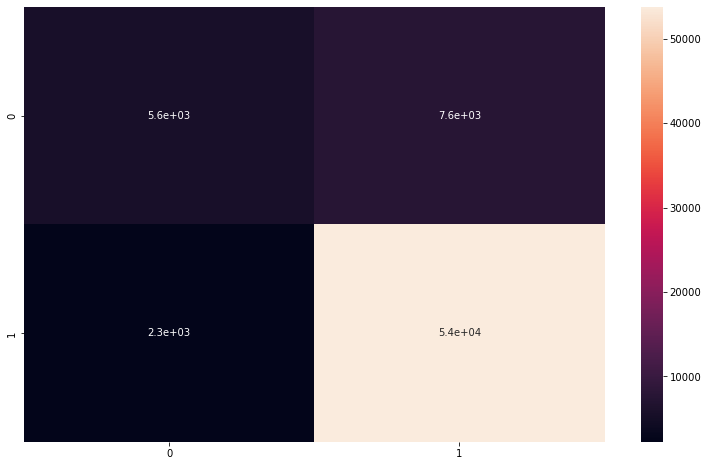

In [31]:
#Confusion Matrix Plot
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, log_predict)
plt.figure(figsize=(13, 8))
sns.heatmap(mat, annot=True)

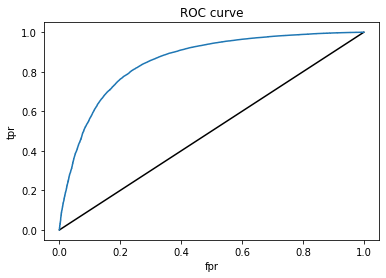

In [32]:
#ROC curve
from sklearn.metrics import roc_curve
y_pred_proba = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k-')
plt.plot(fpr,tpr, label='LogisticREgression')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

In [33]:
#Area under ROC curve
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred_proba)

0.855283221856447

# RandomForest Classifier with n-Gram

In [68]:
###Running Random Forest classifier

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

rfc.score(X_test, y_test)
print("Training set score: {:.3f}".format(rfc.score(X_train, y_train)))
print("Test set score: {:.3f}".format(rfc.score(X_test, y_test)))

Training set score: 1.000
Test set score: 0.835


In [69]:
#Classification report for RandomForest Classifier 
rfc_predict=rfc.predict(X_test)
rfc_bow_report=classification_report(y_test,rfc_predict,target_names=['Negative','Positive'])
print(rfc_bow_report)

              precision    recall  f1-score   support

    Negative       0.82      0.18      0.29     13249
    Positive       0.84      0.99      0.91     56022

    accuracy                           0.84     69271
   macro avg       0.83      0.58      0.60     69271
weighted avg       0.83      0.84      0.79     69271



<AxesSubplot:>

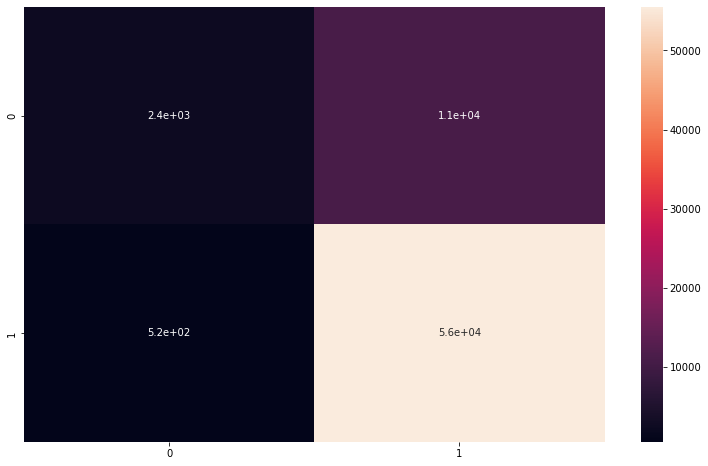

In [70]:
#Confusion Matrix Plot
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, rfc_predict)
plt.figure(figsize=(13, 8))
sns.heatmap(mat, annot=True)

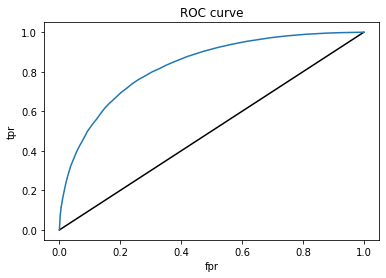

In [71]:
#ROC curve
from sklearn.metrics import roc_curve
y_pred_proba = rfc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k-')
plt.plot(fpr,tpr, label='RF')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

In [72]:
#Area under ROC curve
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred_proba)

0.829663251424368

# KNN classifier with n-Gram

In [43]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train,y_train)
knn.score(X_test, y_test)

0.8069755020138297

In [44]:
#Classification report for KNN Classifier 
knn_predict = knn.predict(X_test)
knn_bow_report=classification_report(y_test,knn_predict,target_names=['Negative','Positive'])
print(knn_bow_report)

              precision    recall  f1-score   support

    Negative       0.48      0.14      0.21     13249
    Positive       0.83      0.97      0.89     56022

    accuracy                           0.81     69271
   macro avg       0.65      0.55      0.55     69271
weighted avg       0.76      0.81      0.76     69271



<AxesSubplot:>

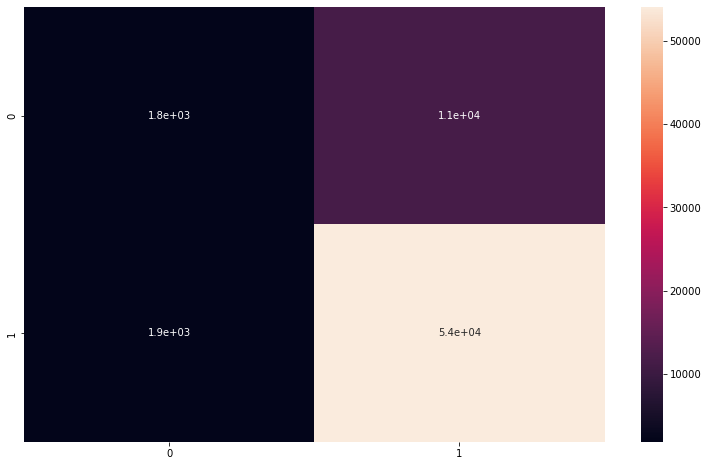

In [45]:
#Confusion Matrix Plot
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, knn_predict)
plt.figure(figsize=(13, 8))
sns.heatmap(mat, annot=True)

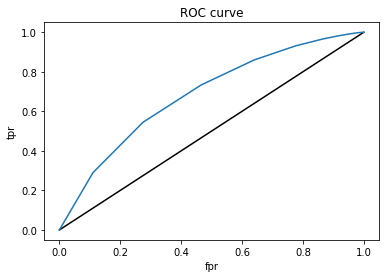

In [74]:
#ROC curve
from sklearn.metrics import roc_curve
y_pred_proba = knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k-')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

In [75]:
#Area under ROC curve
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred_proba)

0.6846925471272071

# XG Boost Classifier BOW with n-Gram

In [34]:
### XGBoost

import xgboost as xg
xgboost = xg.XGBClassifier(n_estimators=100, learning_rate=0.1, gamma=0, subsample=0.5,colsample_bytree=1, max_depth=8,use_label_encoder=False)

xgboost.fit(X_train,y_train)

### Prediction
xg_predict=xgboost.predict(X_test)


[20:25:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [39]:
#Classification report for XG Boost
xg_bow_report=classification_report(y_test,xg_predict,target_names=['Negative','Positive'])
print(xg_bow_report)

              precision    recall  f1-score   support

    Negative       0.78      0.20      0.31     13249
    Positive       0.84      0.99      0.91     56022

    accuracy                           0.84     69271
   macro avg       0.81      0.59      0.61     69271
weighted avg       0.83      0.84      0.79     69271



<AxesSubplot:>

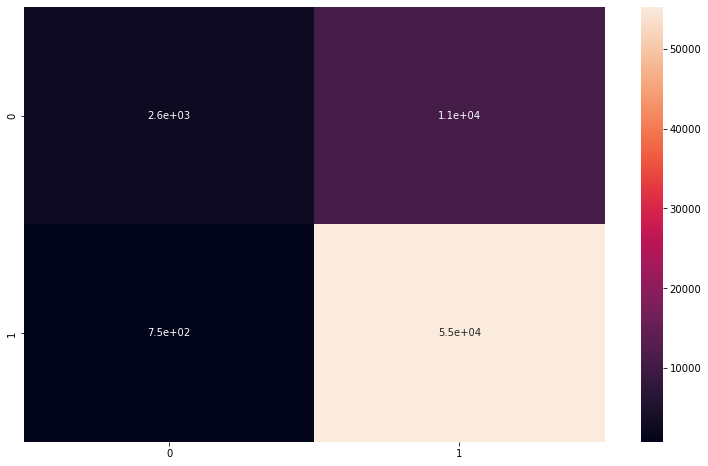

In [40]:
#Confusion Matrix Plot
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, xg_predict)
plt.figure(figsize=(13, 8))
sns.heatmap(mat, annot=True)

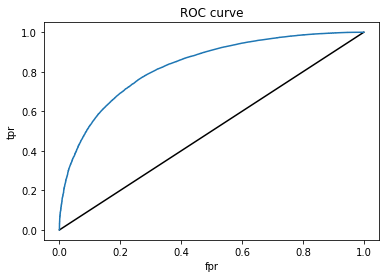

In [41]:
#ROC curve
from sklearn.metrics import roc_curve
y_pred_proba = xgboost.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k-')
plt.plot(fpr,tpr, label='Xgboost')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

In [42]:
#Area under ROC curve
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred_proba)

0.8293102859467465

# TFIDF with ngram

In [78]:

X_train,X_test,y_train,y_test = train_test_split(df_new.reviewText,df_new.review_label,test_size=.2,random_state=0)
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(2,2))
# TF-IDF feature matrix
X_train= tfidf_vectorizer.fit_transform(X_train)
X_test= tfidf_vectorizer.transform(X_test)

In [79]:
dist=pd.DataFrame(y_train.value_counts()/y_train.shape[0]).reset_index()
dist

,index,review_label
0,1,0.807622
1,0,0.192378


# LogisticRegressionTFIDF with n-Gram

In [80]:
### Logistic regression for TFIDF
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=13)
logreg.fit(X_train, y_train)
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))


Training set score: 0.862
Test set score: 0.854


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [81]:
#Classification report for Logistic Regression 
log_predict=logreg.predict(X_test)
log_tfidf_report=classification_report(y_test,log_predict,target_names=['Negative','Positive'])
print(log_tfidf_report)


              precision    recall  f1-score   support

    Negative       0.73      0.38      0.50     13249
    Positive       0.87      0.97      0.91     56022

    accuracy                           0.85     69271
   macro avg       0.80      0.67      0.71     69271
weighted avg       0.84      0.85      0.83     69271



<AxesSubplot:>

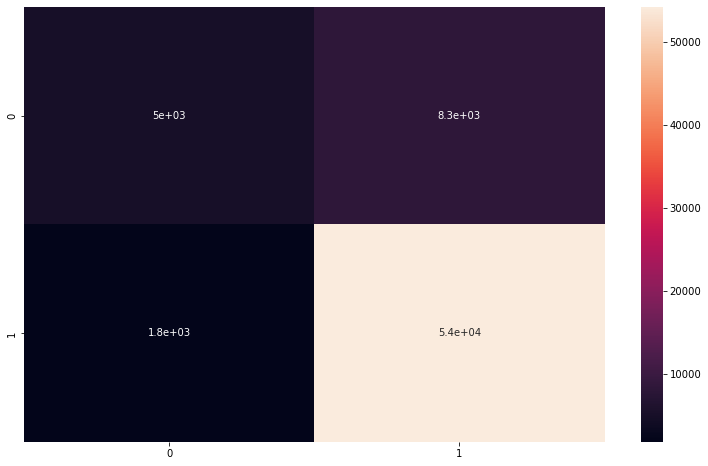

In [82]:
#Confusion Matrix Plot
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, log_predict)
plt.figure(figsize=(13, 8))
sns.heatmap(mat, annot=True)

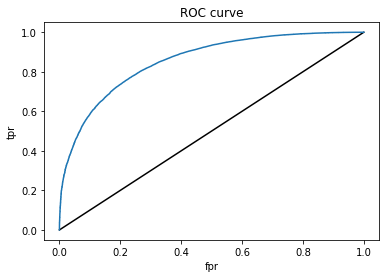

In [83]:
#ROC curve
from sklearn.metrics import roc_curve
y_pred_proba = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k-')
plt.plot(fpr,tpr, label='LogisticREgression')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

In [84]:
#Area under ROC curve
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred_proba)

0.8550594101350676

# XGBOOST TFIDF with n-Gram

In [86]:
### XGBoost

import xgboost as xg
xgboost = xg.XGBClassifier(n_estimators=100, learning_rate=0.1, gamma=0, subsample=0.5,colsample_bytree=1, max_depth=8,use_label_encoder=False)

xgboost.fit(X_train,y_train)

### Prediction
xg_predict=xgboost.predict(X_test)

[17:47:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [51]:
#Classification Report for XGboost Classifier
xg_tfidf_report=classification_report(y_test,xg_predict,target_names=['Negative','Positive'])
print(xg_tfidf_report)

              precision    recall  f1-score   support

    Negative       0.78      0.20      0.31     13249
    Positive       0.84      0.99      0.91     56022

    accuracy                           0.84     69271
   macro avg       0.81      0.59      0.61     69271
weighted avg       0.83      0.84      0.79     69271



<AxesSubplot:>

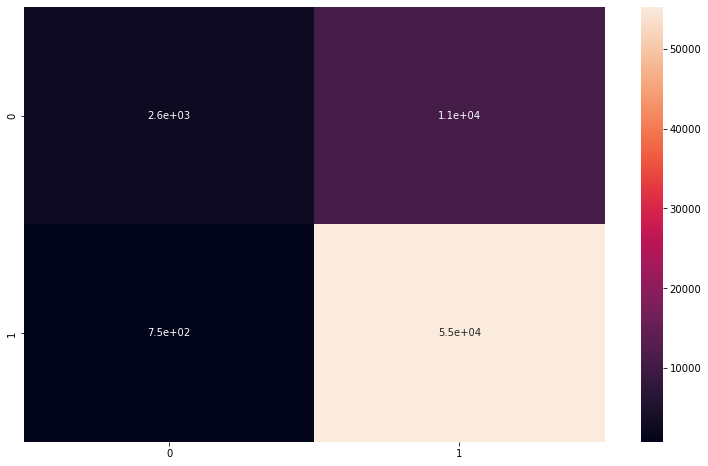

In [52]:
#Confusion Matrix Plot
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, xg_predict)
plt.figure(figsize=(13, 8))
sns.heatmap(mat, annot=True)

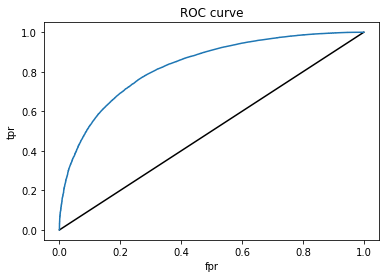

In [53]:
#ROC curve
from sklearn.metrics import roc_curve
y_pred_proba = xgboost.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k-')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

In [54]:
#Area under ROC curve for XGboost Classifier
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred_proba)

0.8293102859467465

# RandomForest Classifier TFIDF with n-Gram

In [46]:
###Running Random Forest classifier

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

rfc.score(X_test, y_test)
print("Training set score: {:.3f}".format(rfc.score(X_train, y_train)))
print("Test set score: {:.3f}".format(rfc.score(X_test, y_test)))

Training set score: 1.000
Test set score: 0.838


In [47]:
#Classification report for RandomForest Classifier 
rfc_predict=rfc.predict(X_test)
rfc_tfidf_report=classification_report(y_test,rfc_predict,target_names=['Negative','Positive'])
print(rfc_tfidf_report)

              precision    recall  f1-score   support

    Negative       0.81      0.20      0.32     13249
    Positive       0.84      0.99      0.91     56022

    accuracy                           0.84     69271
   macro avg       0.82      0.59      0.61     69271
weighted avg       0.83      0.84      0.80     69271



<AxesSubplot:>

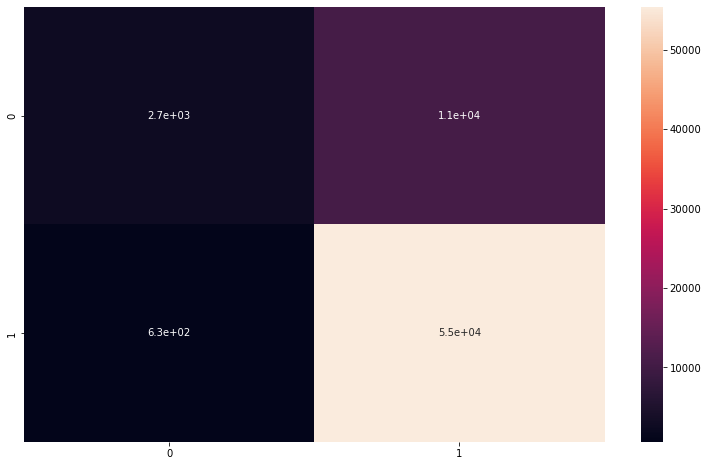

In [48]:
#Confusion Matrix Plot
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, rfc_predict)
plt.figure(figsize=(13, 8))
sns.heatmap(mat, annot=True)

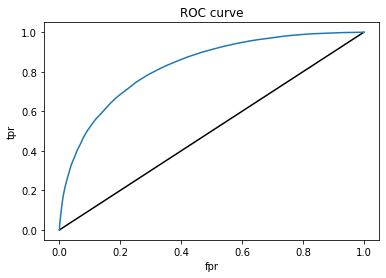

In [49]:
#ROC curve
from sklearn.metrics import roc_curve
y_pred_proba = rfc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k-')
plt.plot(fpr,tpr, label='RF')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

In [50]:
#Area under ROC curve for RandomForest Classifier
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred_proba)

0.8281893485560388

# XG boost is performing best as it has good recall and highest AUC score amongst all models and is therefore choosen as the selected model for classification.